# Exploring and Visualizing BioSCape PRISM Data
## <center>BioSCape Data Skills Workshop: From the Field to the Image</center>
<center><img src="images/121229-87.png"/></center>

[**BioSCape**](https://www.bioscape.io/), the Biodiversity Survey of the Cape, is NASA’s first biodiversity-focused airborne and field campaign that was conducted in South Africa in 2023. BioSCape’s primary objective is to study the structure, function, and composition of the region’s ecosystems, and how and why they are changing. 

BioSCape's airborne dataset is unprecedented, with `AVIRIS-NG`, `PRISM`, and `HyTES` imaging spectrometers capturing spectral data across the UV, visible and infrared at high resolution and `LVIS` acquiring coincident full-waveform lidar. BioSCape's `field dataset` is equally impressive, with 18 PI-led projects collecting data ranging from the diversity and phylogeny of plants, kelp and phytoplankton, eDNA, landscape acoustics, plant traits, blue carbon accounting, and more

This workshop will equip participants with the skills to find, subset, and visualize the various BioSCape field and airborne (imaging spectroscopy and full-waveform lidar) data sets. Participants will learn data skills through worked examples in terrestrial and aquatic ecosystems, including: wrangling lidar data, performing band math calculations, calculating spectral diversity metrics, machine learning and image classification, and mapping functional traits using partial least squares regression. The workshop format is a mix of expert talks and interactive coding notebooks and will be run through the BioSCape Cloud computing environment.

**Date:** October 9 - 11, 2024 Cape Town, South Africa</center>

**Host:** NASA’s Oak Ridge National Laboratory Distributed Active Archive Center (ORNL DAAC), in close collaboration with BioSCape, the South African Environmental Observation Network (SAEON), the University of Wisconsin Madison (Phil Townsend), The Nature Conservancy (Glenn Moncrieff), the University of California Merced (Erin Hestir), the University of Cape Town (Jasper Slingsby), Jet Propulsion Laboratory (Kerry Cawse-Nicholson), and UNESCO.

**Instructors:** 
- In-person contributors: Anabelle Cardoso, Erin Hestir, Phil Townsend, Henry Frye, Glenn Moncrieff, Jasper Slingsby, Michele Thornton, Rupesh Shrestha
- Virtual contributors: Kerry Cawse-Nicholson, Nico Stork, Kyle Kovach

**Audience:** This training is primarily intended for government natural resource management agency representatives and field technicians in South Africa, as well as local academics and students, especially those connected to the BioSCape Team. 

----

## Overview 
----

This tutorial will demonstrate accessing and visualizing PRISM data available on the BioSCape SMCE.  The data available data are L2 reflectance data in ENVI file formats.

The **Portable Remote Imaging Spectrometer (PRISM)** is comprised of a pushbroom imaging spectrometer covering the near UV to near IR range (350-1050 nm) and a separate spot radiometer. The PRISM two-channel spot radiometer at short-wave infrared (SWIR) bands (1240 nm and 1640 nm) provides accurate atmospheric correction of ocean and aquatic color measurements.  

- pushbroom imaging spectrometer
- two-channel spot radiometer

PRISM was developed by the Jet Propulsion Laboratory (JPL) to survey coastal zones.  Coastal zones are home to a high fraction of humanity and are increasingly affected by natural and human-induced events from tsunamis to toxic blooms and oil spills. PRISM is a compact, lightweight imaging spectroMeter compatible with a wide range of piloted and Uninhabited Aerial Vehicle (UAV) platforms.  
    

<center><img src="images/index_main_image_rs.png"/></center>

| Dataset | Description | 
| -------- | --- |
| L1B | Resampled calibrated data in units of spectral radiance.  Observed geometry and illumination parameters |
| L2 | Orthocorrected and atmospherically corrected reflectance data.   (246 Spectral bands)|

### Learning Objectives
1.  Mount BioSCape SMCE S3 BioSCape object storage and explore file content
2.  Examine PRISM Reflectance ENVI data using GDAL
3.  Visualize a flight line of PRISM L2 data
4.  Extract and graph spectral profiles for point locations
5.  Create and save a 3-band RGB GeoTIFF file from the PRISM ENVI file
6.  Visualize the true color geoTIFF in QGIS

### Requirements
----


### Load Python Modules

In [1]:
import s3fs
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy as np
import pandas as pd
from os import path
import rioxarray
gdal.UseExceptions()

## Explore the BioSCape SMCE S3 PRISM data holdings

Let's start by exploring the BioSCape Airborne currently data available on the cloud in Amazon Storage. This AWS S3 storage is specific to the SMCE that provides data access and analytics environment to the BioSCape Science Team as well as interested researchers.  
We'll learn how to mount the S3 object storage on our local environment, as well as learning how to bring other data to the analysis.

- **SMCE** = Science Managed Cloud Environment
- **S3** = Amazon Simple Storage Service (S3) is a cloud storage service that allows users to store and retrieve data
- **S3Fs** is a `Pythonic` open source tool that mounts S3 object storage locally.  S3Fs provides a filesystem-like interface for accessing objects on S3.
    - The top-level class **`S3FileSystem`** holds connection information and allows typical file-system style operations like `ls`
    - `ls` is a UNIX command to list computer files and directories

In [2]:
# Use S3Fs to list the BioSCape data on the BioSCape SMCE S3 storaage
s3 = s3fs.S3FileSystem(anon=False)
files = s3.ls('bioscape-data/')
files

['bioscape-data/AVNG',
 'bioscape-data/BioSCapeVegPolys2023_10_18',
 'bioscape-data/BioSCapeVegPolys2023_10_18.geoparquet',
 'bioscape-data/LVIS',
 'bioscape-data/PRISM',
 'bioscape-data/bioscape_avng.yaml']

### Portable Remote Imaging Spectrometer (PRISM)

In [3]:
PRISM_flightlines = s3.ls('bioscape-data/PRISM')
PRISM_flightlines

['bioscape-data/PRISM/L2']

### There are Level 2 (L2) Reflectance data for PRISM in the BioSCape SCME

In [4]:
PRISM_flightlines = s3.ls('bioscape-data/PRISM/L2')
PRISM_flightlines[:10]
#PRISM_flightlines

['bioscape-data/PRISM/L2/prm20231022t141344_rfl_ort',
 'bioscape-data/PRISM/L2/prm20231022t141344_rfl_ort.hdr',
 'bioscape-data/PRISM/L2/prm20231025t060817_rfl_ort',
 'bioscape-data/PRISM/L2/prm20231025t060817_rfl_ort.hdr',
 'bioscape-data/PRISM/L2/prm20231025t062740_rfl_ort',
 'bioscape-data/PRISM/L2/prm20231025t062740_rfl_ort.hdr',
 'bioscape-data/PRISM/L2/prm20231025t063541_rfl_ort',
 'bioscape-data/PRISM/L2/prm20231025t063541_rfl_ort.hdr',
 'bioscape-data/PRISM/L2/prm20231025t064655_rfl_ort',
 'bioscape-data/PRISM/L2/prm20231025t064655_rfl_ort.hdr']

In [5]:
PRISM_flights_cnt = [x for x in PRISM_flightlines if x.endswith('rfl_ort')]
len(PRISM_flights_cnt)

84

### There are 84 PRISM flight lines in the BioSCape SMCE

- PRISM files on the SMCE in ENVI file formats which are binary/header pairs
    - prm20231126t080430_rfl_ort.hdr  
    - prm20231126t080430_rfl_ort
- Let's examine the header file of one of the ENVI tiles

In [6]:
# The next block prints only the first 12 lines of the header file. 
# Uncomment to see the whole header file

#hdr_link = 'bioscape-data/PRISM/L2/prm20231126t080430_rfl_ort.hdr'
#with s3.open(hdr_link, mode='r') as hdr:
#    lines = (hdr.read())
#    print(lines)  

In [7]:
# print the first 12 lines of the header file
hdr_link = 'bioscape-data/PRISM/L2/prm20231126t080430_rfl_ort.hdr'
hdr_link

with s3.open(hdr_link, mode='r') as hdr:
    for i in range(12):
        line = next(hdr).strip()
        print(line)  

ENVI
description = {
}
samples = 655
lines = 2789
bands = 246
header offset = 0
file type = ENVI
data type = 4
interleave = bil
byte order = 0
map info = {UTM, 1, 1, 334572.145865, 6235944.24235, 2.5, 2.5, 34, South, WGS-84, units=Meters, rotation=-81.0000000}


**`map info`** provides:
- `Projection:` UTM, Zone 34, South, WGS-84
- `Pixel Size:` 2.5 x 2.5 meters
- `Grid Rotation:`  -81 degrees

## Examine PRISM Reflectance Data as a GDAL Raster Dataset

- **`GDAL`** (Geospatial Data Abstraction Library) is a translator library for raster and vector geospatial data formats

In this step, we will use GDAL to examine the PRISM reflectance data that is in ENVI binary format (a proprietary, but common distribution format)  
- We need to configure our S3 credentials for GDAL
- The GDAL utility expects S3 links to be formated with the `GDAL virtual file system (VSI)` S3 path.  We therefore have to use the VSI path to access the files with GDAL.  We'll substitute the S3 link with the VSI (`vsis3`) link(s). 

In [8]:
rfl_link = 'bioscape-data/PRISM/L2/prm20231126t080430_rfl_ort'

In [9]:
image_open = gdal.Open(path.join('/vsis3', rfl_link))
#image_open.GetMetadata()

In [10]:
# lists of band numbers and band center
band_numbers = [int(b.split("_")[1]) for b in image_open.GetMetadata().keys() if b != "wavelength_units"]
band_wavelength = [float(b.split(" ")[0]) for b in image_open.GetMetadata().values() if b != "Nanometers"]

# data frame describing bands
bands = pd.DataFrame({ 
    "Band number": band_numbers, 
    "Band wavelength (nm)": band_wavelength}, index = band_wavelength).sort_index()

print(bands.to_string())

             Band number  Band wavelength (nm)
350.554829             1            350.554829
353.385086             2            353.385086
356.215399             3            356.215399
359.045768             4            359.045768
361.876193             5            361.876193
364.706675             6            364.706675
367.537213             7            367.537213
370.367807             8            370.367807
373.198457             9            373.198457
376.029164            10            376.029164
378.859927            11            378.859927
381.690746            12            381.690746
384.521621            13            384.521621
387.352553            14            387.352553
390.183541            15            390.183541
393.014585            16            393.014585
395.845685            17            395.845685
398.676841            18            398.676841
401.508054            19            401.508054
404.339323            20            404.339323
407.170649   

In [11]:
# need to sort the wavelengths for later plotting
band_wavelength.sort()
#print(band_wavelength)

In [12]:
# Open the PRISM ENVI file and read the file bands, row, cols
#image_open = gdal.Open(gdal_url)

nbands = image_open.RasterCount
nrows = image_open.RasterYSize
ncols = image_open.RasterXSize

print("\n".join(["Bands:\t"+str(nbands), "Rows:\t"+str(nrows), "Cols:\t"+str(ncols)]))

Bands:	246
Rows:	2789
Cols:	655


In [13]:
# GDAL can interpret the ENVI Header the projection information
print("ENVI image WKT: \n"+str(image_open.GetProjection()))
image_proj = image_open.GetProjection()

ENVI image WKT: 
PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",21],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",10000000],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


### Using GDAL to read a raster file as a numerical array
- convert an existing `Gdal Dataset` or a Band into a numpy array with the `ReadAsArray()` function

In [14]:
#### This block takes a while to run.  The output is provided as an image below this block for workshop convenience.  

#### uncomment ONE of the GetRaseterBand lines to GetRasterBand or plot.  
#### The img_red is shown in the plot.

#img_red = image_open.GetRasterBand(109).ReadAsArray()  # Band 109 is 657nm 
##img_green = image_open.GetRasterBand(70).ReadAsArray()  # Band 70 is 546nm 
####img_blue = image_open.GetRasterBand(47).ReadAsArray()  # Band 47 is 481nm 
#plt.scatter(300,770, color='red')
#plt.scatter(75,770, color='black')
#plt.rcParams['figure.figsize'] = [10,10]
#plt.rcParams['figure.dpi'] = 100
#plt.imshow(img_red, vmin=-0, vmax=.20)
##plt.imshow(img_green, vmin=0, vmax=0.20)
####plt.imshow(img_blue, vmin=0, vmax=0.20)
#plt.colorbar()
#plt.show()

<center><img src="images/PRISM_redband2plots_grab.PNG"/></center>

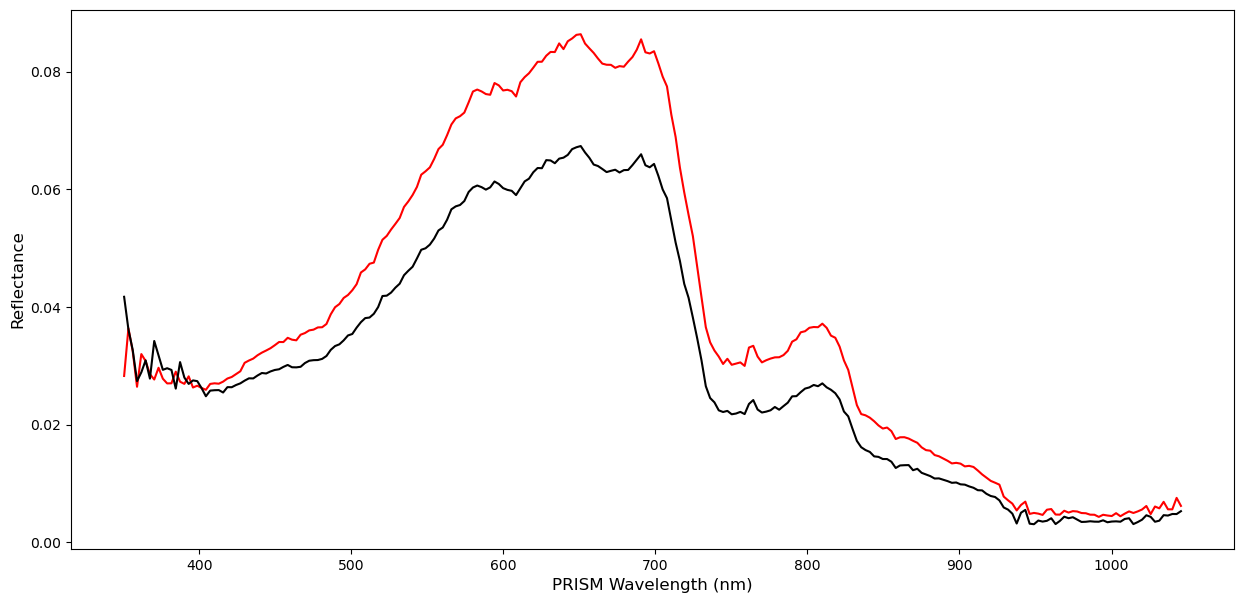

In [15]:
# Compare spectra of two different aquatic plots
pixel1 = image_open.ReadAsArray(300, 770, 1, 1) #  pixel location: col, row
pixel2 = image_open.ReadAsArray(75, 770, 1, 1) # pixel location: col, row
pixel1 = np.reshape(pixel1, (246))
pixel2 = np.reshape(pixel2, (246))

plt.rcParams['figure.figsize'] = [15,7]
plt.plot(band_wavelength, pixel1, color = 'red')
plt.plot(band_wavelength, pixel2, color = 'black')
plt.xlabel('PRISM Wavelength (nm)', fontsize=12)
plt.ylabel('Reflectance', fontsize=12)
plt.show()

#
##### <center>SEA WATER TURBIDITY ANALYSIS FROM SENTINEL-2 IMAGES: ATMOSPHERIC CORRECTION AND BANDS CORRELATION</center>
<center><img src="images/turgidwater.png"/></center>
Spectral signatures of water with sediments (orange), clear water (blue), water with chlorophyll content (green), water with Chromophoric Dissolved Organic Matter -CDOM (black). Rrs is the reflectance registered by the sensor. Source: Hafeez et al. (2018).  

[SEA WATER TURBIDITY ANALYSIS FROM SENTINEL-2 IMAGES: ATMOSPHERIC CORRECTION AND BANDS CORRELATION](https://doi.org/10.5194/isprs-archives-XLVIII-4-W1-2022-371-2022)

## Export R,G,B to a 3-band projected geoTIFF

### GDAL's raster library uses the `GDALDataset` class to obtain properties of a raster image
- GetRasterBand
- GetProjection
- GetGeoTransform

In [ ]:
img_red = image_open.GetRasterBand(109).ReadAsArray()  # Band 109 is 657nm red
img_green = image_open.GetRasterBand(70).ReadAsArray()  # Band 70 is 546nm green
img_blue = image_open.GetRasterBand(47).ReadAsArray()  # Band 47 is 481nm  blue

outfile = ('prism_rgb.tif')
rows = image_open.RasterYSize
cols = image_open.RasterXSize
datatype = image_open.GetRasterBand(1).DataType
projection = image_open.GetProjection()
transform = image_open.GetGeoTransform()

driver = gdal.GetDriverByName("GTiff")
DataSetOut = driver.Create(outfile, cols, rows, 3, datatype)
DataSetOut.GetRasterBand(1).WriteArray(img_red)
DataSetOut.GetRasterBand(2).WriteArray(img_green)
DataSetOut.GetRasterBand(3).WriteArray(img_blue)
DataSetOut.SetProjection(projection)
DataSetOut.SetGeoTransform(transform)
DataSetOut = None

### Open QGIS in the Hub Desktop, 
- From a **`Launcher`** tab, start the Desktop
- At the bottom of the Desktop screen, use the Application Finder to find and launch QGIS
- start QGIS,
- using the **`Home`** file system, maneuver to the correct file folder containing the prism_rgb.tif file,
- and view the prism_rgb.tif image you just created !
    - HINT:  under Symbology, set the `Min/Max Value Settings` of the image in QGIS to Whole Raster | Actual (slow)
    - HINT: under Transparency, set the `NoData` value to 0



<center><img src="images/Desktop_applicationfinder_QGIS.PNG"/></center>

- a copy of the output prism_rgb.tiff file is in the workshop folder `//shared/users/bioscape_ZA24workshop_data/RS_data/PRISM_Notebook`